In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        
        """
        min(D_KL) = min (-p*log(q) - (1-p)*log(1-q))
        """
        
        
        dkl = -rho * torch.log(self.data_rho) - (1 - rho)*torch.log(1 - self.data_rho)
        
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.016721 32: 1.019665 64: 1.015968
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.894368 32: 0.863921 64: 0.725200
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.846422 32: 0.691366 64: 0.457663
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.767259 32: 0.530266 64: 0.372726
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.636578 32: 0.423215 64: 0.320112
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.556617 32: 0.393841 64: 0.301797
Test set:
16: loss: 0.5474	rho_loss: 0.0059
32: loss: 0.3826	rho_loss: 0.0063
64: loss: 0.2912	rho_loss: 0.0059

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.555086 32: 0.391642 64: 0.297048
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.494693 32: 0.361142 64: 0.278332
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.418111 32: 0.308851 64: 0.241866
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.402213 32: 0.304635 64: 0.236060
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.365396 32: 0.278137 64: 0.209947
Train

Test set:
16: loss: 0.1679	rho_loss: 0.0043
32: loss: 0.1247	rho_loss: 0.0043
64: loss: 0.0872	rho_loss: 0.0042

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.161173 32: 0.118990 64: 0.085246
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.160344 32: 0.120356 64: 0.081029
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.151733 32: 0.111754 64: 0.074165
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.163937 32: 0.124879 64: 0.087339
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.166344 32: 0.119923 64: 0.084091
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.163420 32: 0.116627 64: 0.081712
Test set:
16: loss: 0.1649	rho_loss: 0.0043
32: loss: 0.1221	rho_loss: 0.0043
64: loss: 0.0844	rho_loss: 0.0042

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.170134 32: 0.126188 64: 0.085706
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.170973 32: 0.125966 64: 0.087246
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.151981 32: 0.110205 64: 0.076092
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

In [9]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([3, 4, 1, 3, 2, 3, 4, 1, 4, 3, 5, 6, 2, 4, 4, 2, 3, 5, 4, 3, 3, 4, 3, 4,
        0, 5, 5, 4, 5, 3, 4, 4, 6, 4, 4, 3, 2, 4, 1, 3, 4, 3, 5, 3, 3, 2, 3, 0,
        4, 3])


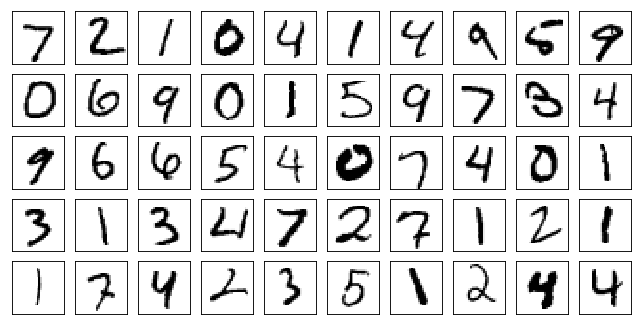

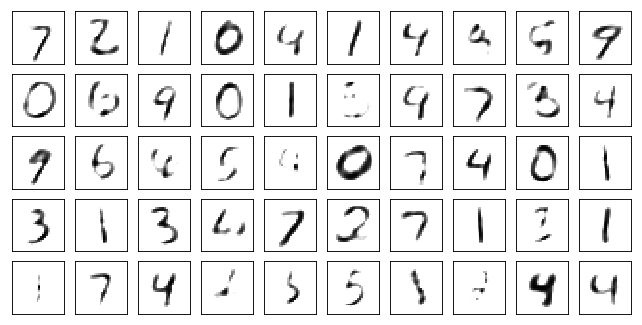

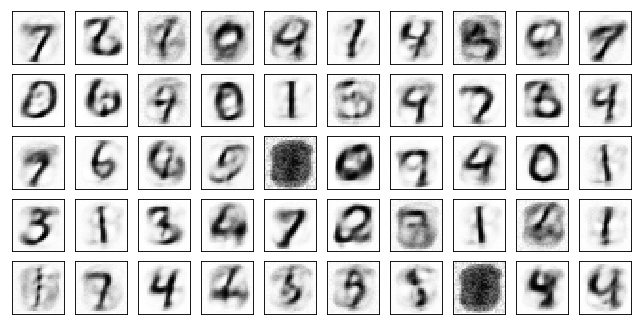

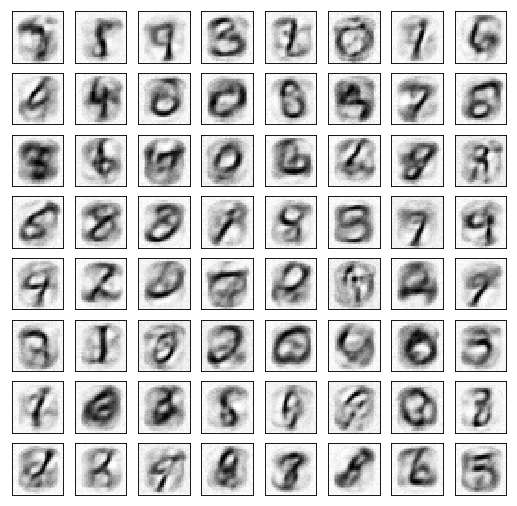

In [10]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))